In [ ]:
import numpy as np
import scipy
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors

def getIDL(graphMatrix : np.array):
  # indirect laplacian
  # L = D - W

  InDegreeLaplacian = -graphMatrix
  D = np.identity(graphMatrix.shape[0])

  for i in range(graphMatrix.shape[0]):
    InDegreeLaplacian[i][i]+= sum(graphMatrix[:][i])
    D[i][i] = sum(graphMatrix[:][i])

  return (InDegreeLaplacian, D)

def getLRW(graphMatrix : np.array):
  # right walk laplacian
  # D^(-1) @ L

  InDegreeLaplacian = -graphMatrix
  invD = np.identity(graphMatrix.shape[0])

  for i in range(graphMatrix.shape[0]):
    InDegreeLaplacian[i][i]+= sum(graphMatrix[:][i])
    invD[i][i] = 1/sum(graphMatrix[:][i])
  res = invD @ InDegreeLaplacian

  return invD @ InDegreeLaplacian

def HeatKernel(dist : float, t : float):
  return np.exp(-dist**2/t)

def buildGraphFromData( data : np.array, k_neighbours : int, sigma : float, mode = "distance"):
  # using KNN-neighbours

  KNN = NearestNeighbors(n_neighbors = k_neighbours, algorithm = "brute", p = 2)
  KNN.fit(data)

  if(mode == "distance"):
    matrix = KNN.kneighbors_graph(data, mode = "distance").toarray()
    n,m = matrix.shape

    for i in range(m):
      for j in range(n):
        if(matrix[i][j]!=0):
          matrix[i][j] = HeatKernel(matrix[i][j],sigma)
  else:

    matrix = KNN.kneighbors_graph(data, mode = "connectivity").toarray()
    matrix = 0.5 * (matrix + matrix.T)

  return matrix

def getSolutionToGEP( dims : int, leftMatrix : np.array, rightMatrix : np.array = None, eps = 1e-10):

  solution = scipy.linalg.eigh(leftMatrix, rightMatrix)
  eigenValues = [x for x in solution[0]]
  eigenVectors = [solution[1][:,i] for i in range(len(eigenValues))]

  res = []

  for i in range(len(eigenValues)):
    if(eigenValues[i]>eps):
      res.append([eigenValues[i],eigenVectors[i]])


  return res[:dims]

def tryToEmbed(data : np.array, k : int, dims : int, mode = "connectivity", sigma = 2.0):
  res = buildGraphFromData(data,k,sigma,mode)
  #l, r = getNSL(res)
  #basis = getSolutionToGEP(dims, l @ r,r)
  basis = getSolutionToGEP(dims, )
  #l, r = getIDL(res)
  #basis = getSolutionToGEP(dims, l ,r)


  return basis

def draw2D(eigenVectors, k, sigma, colors = None):
  fig, axs = plt.subplots(figsize=(8, 8))
  if colors is None:
    axs.scatter(eigenVectors[0][1],
                eigenVectors[1][1], c=np.linspace(0, 25, len(eigenVectors[0][1])), cmap='viridis')
  else:
    axs.scatter(eigenVectors[0][1],
                eigenVectors[1][1], c=colors, cmap='viridis')
  axs.set_title("K:" + str(k) + " Sigma:" + str(sigma))
def draw3D(eigenVectors, k, sigma, azim, elev):
  fig = plt.figure(figsize=(8, 6))
  ax = fig.add_subplot(111, projection="3d")
  fig.add_axes(ax)
  ax.scatter(
      eigenVectors[0][1],
      eigenVectors[1][1],
      eigenVectors[2][1],
      c=np.linspace(0, 25, len(eigenVectors[0][1])), s=10, alpha=0.8, cmap='viridis'
  )
  ax.view_init(azim=azim, elev=elev)
  ax.set_title("K:" + str(k) + " Sigma:" + str(sigma))

<ipython-input-1-e1212f908fae>:70: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, axs = plt.subplots(figsize=(8, 8))


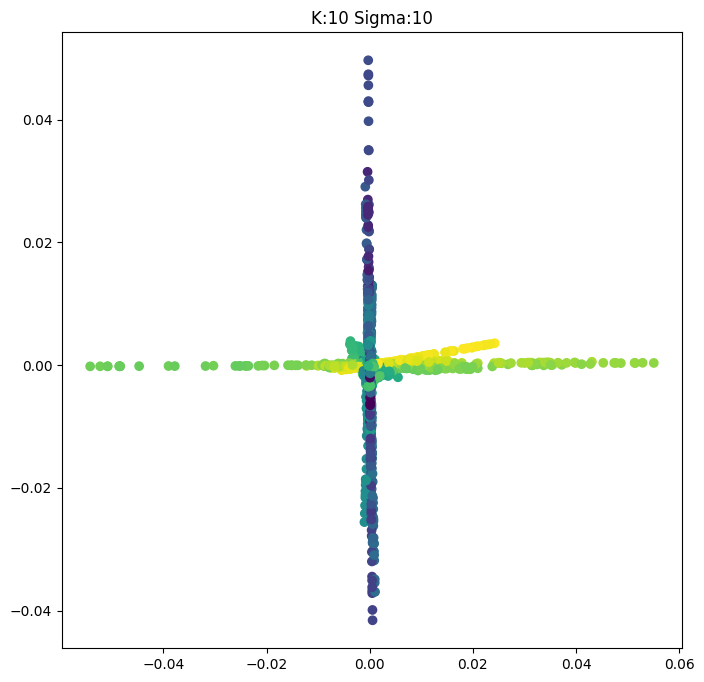

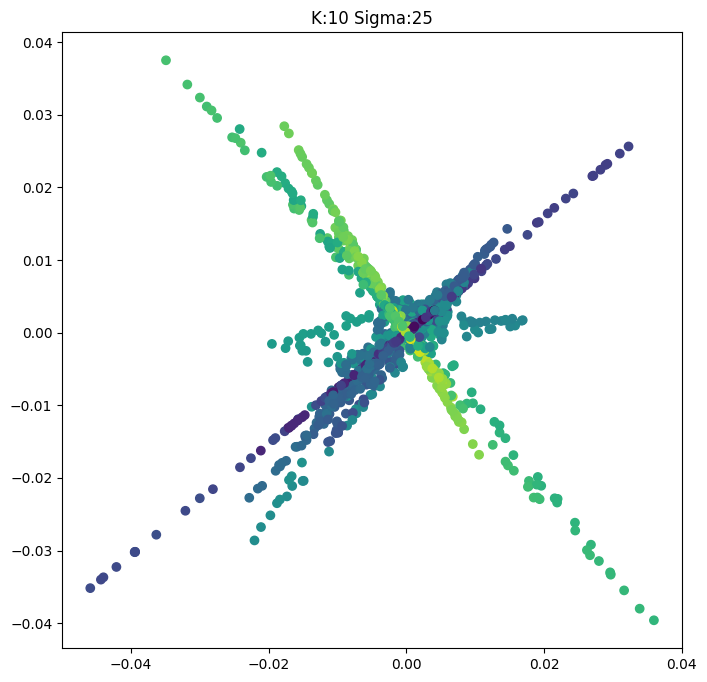

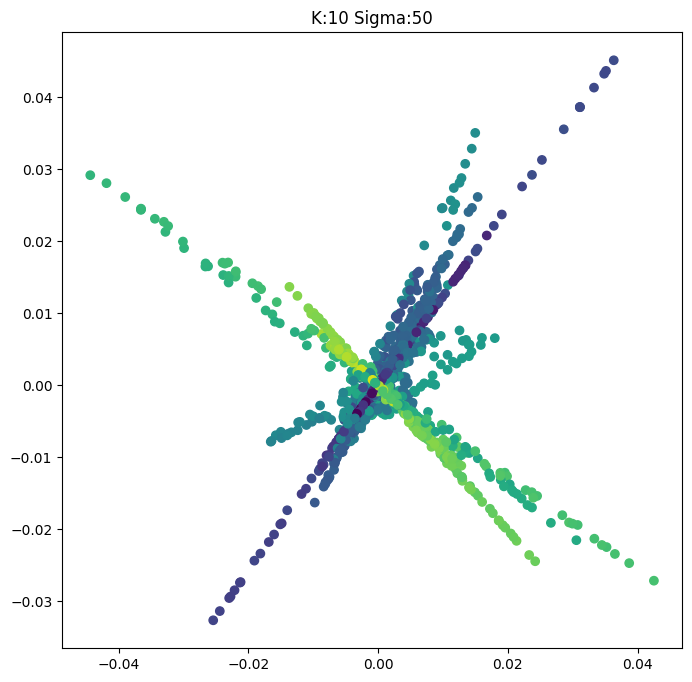

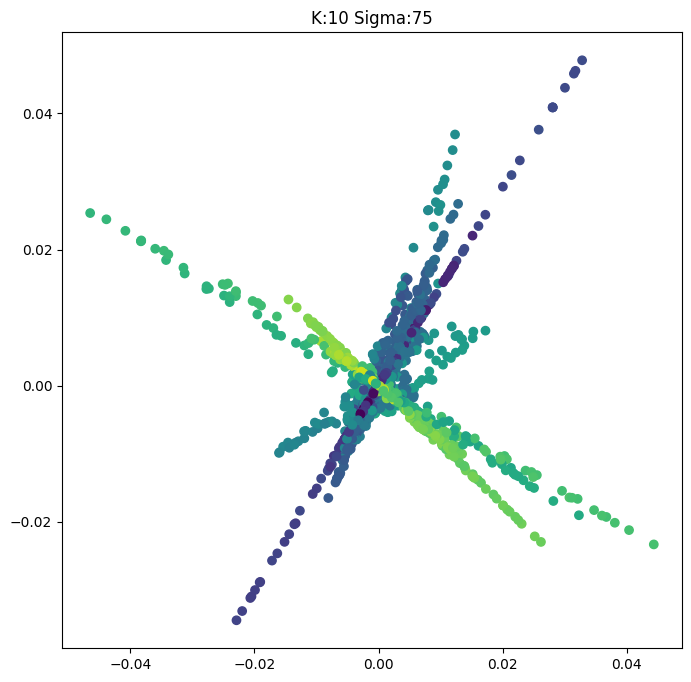

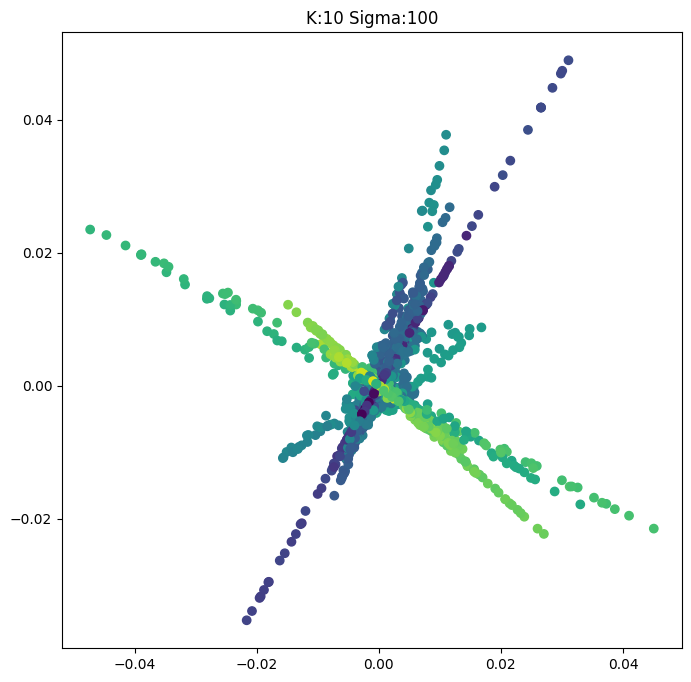

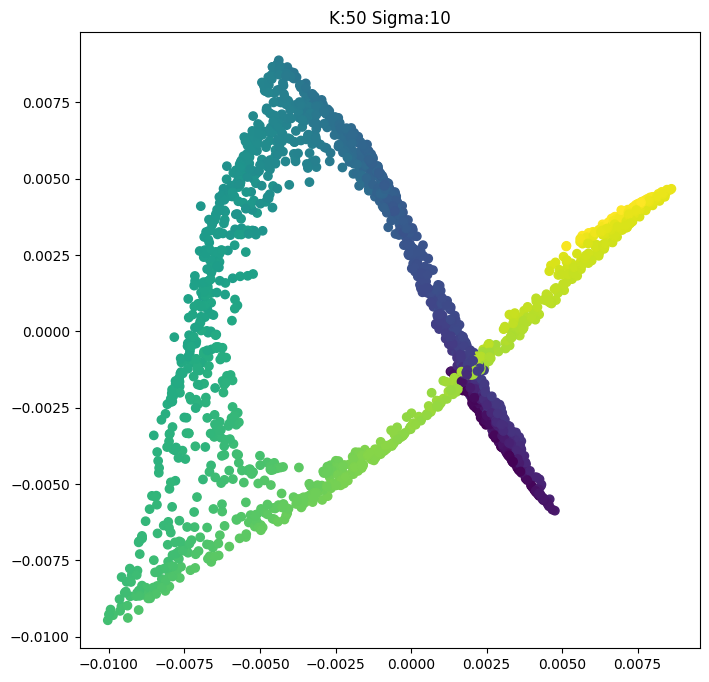

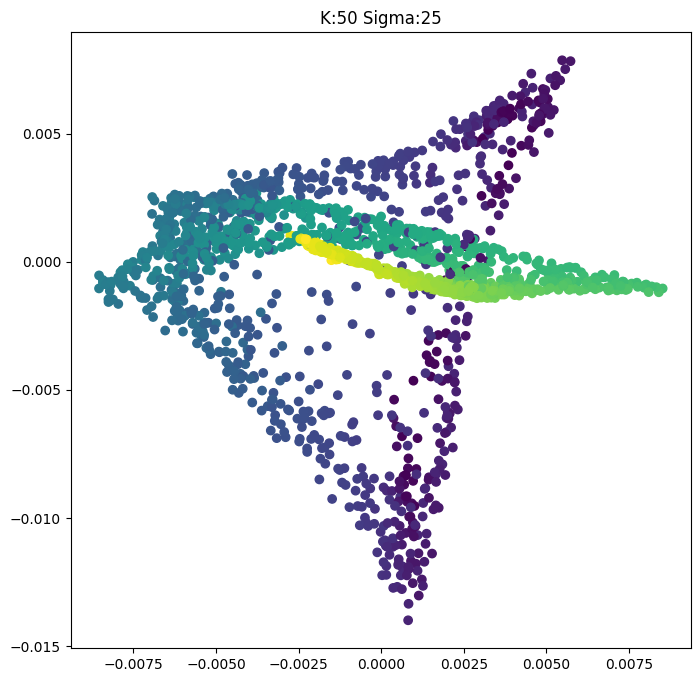

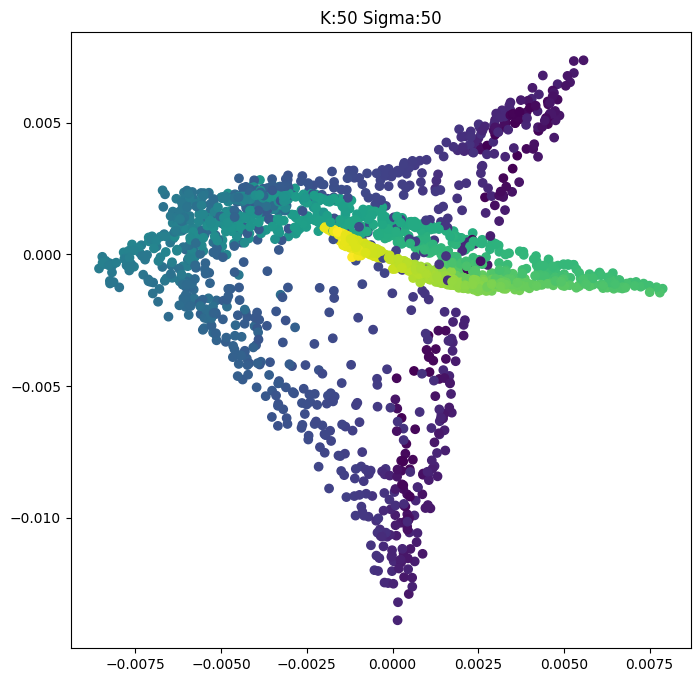

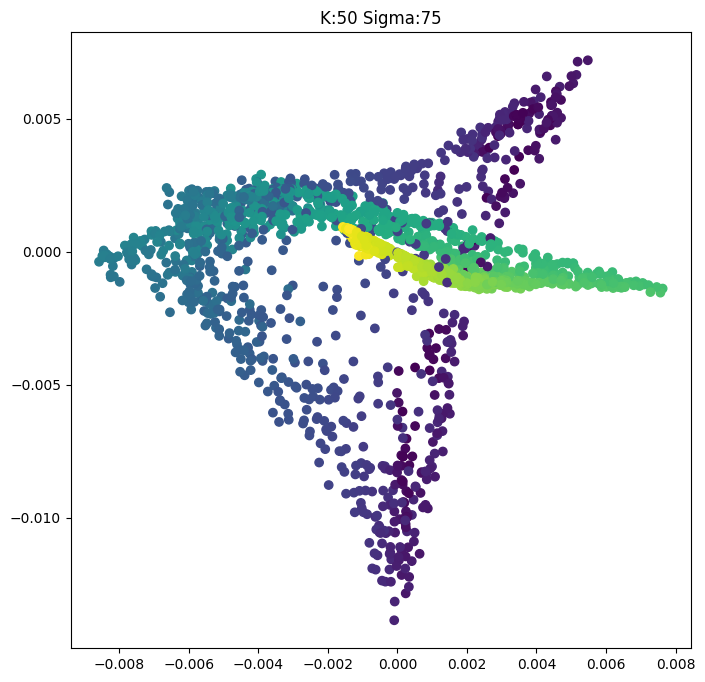

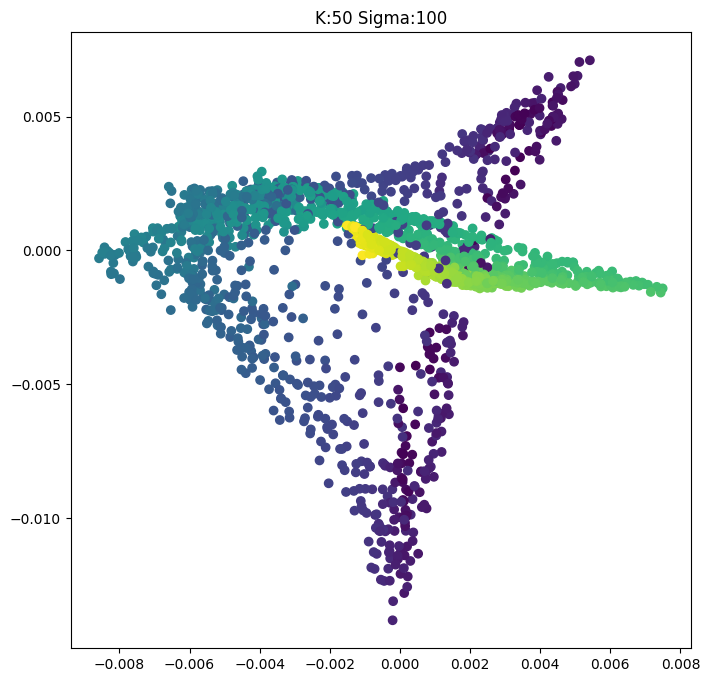

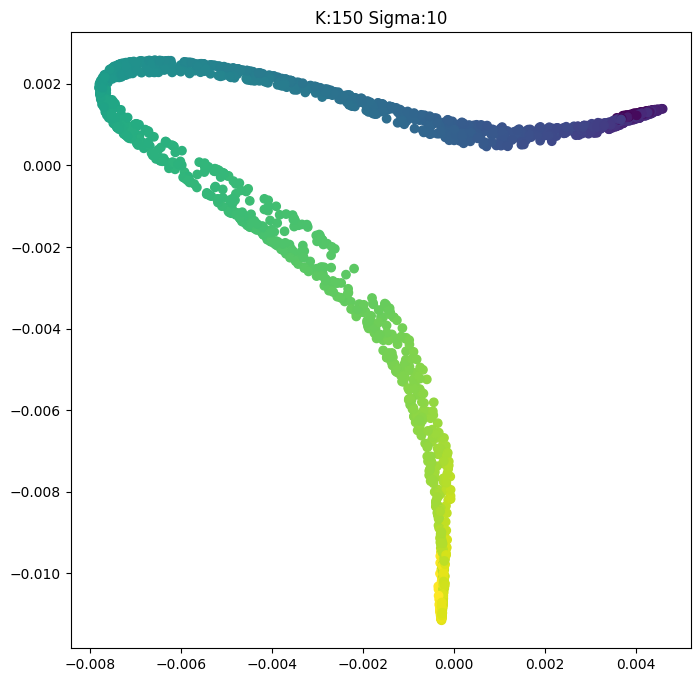

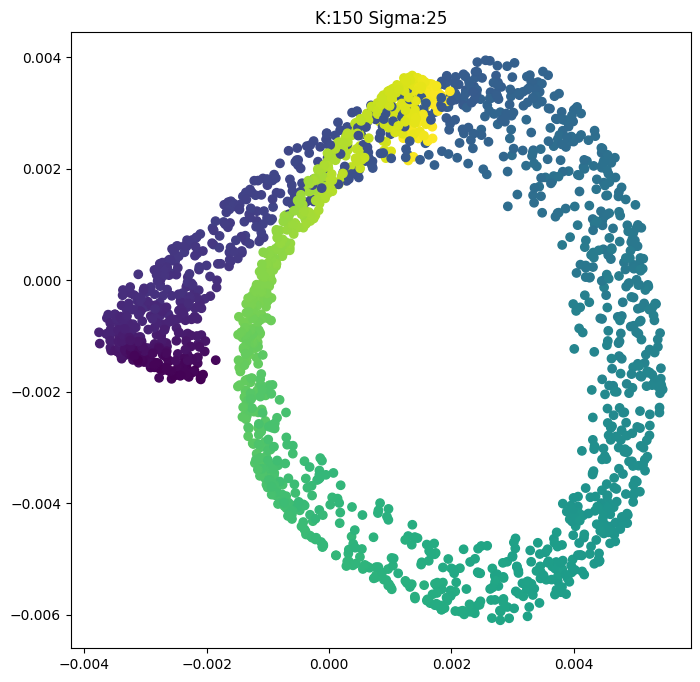

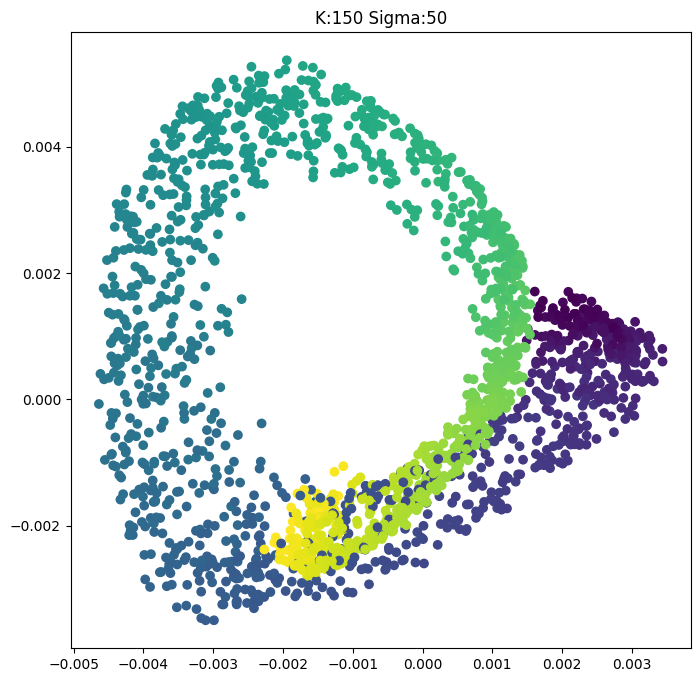

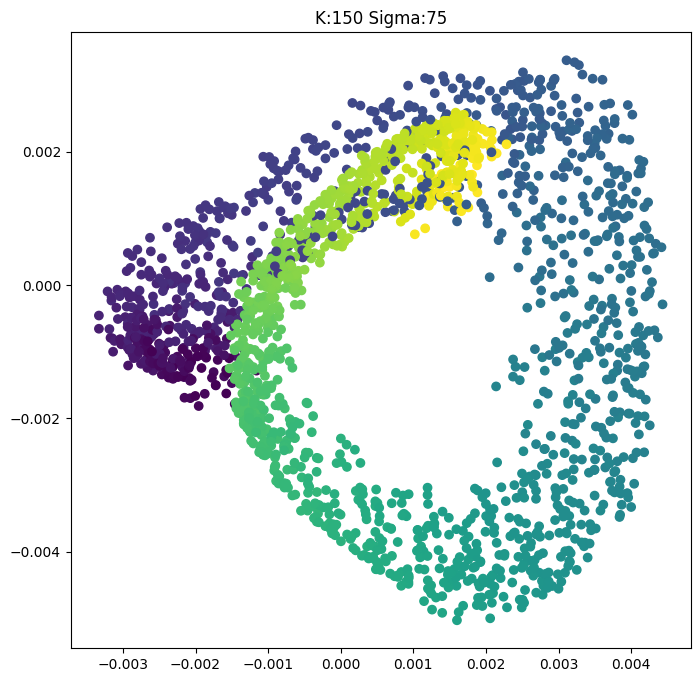

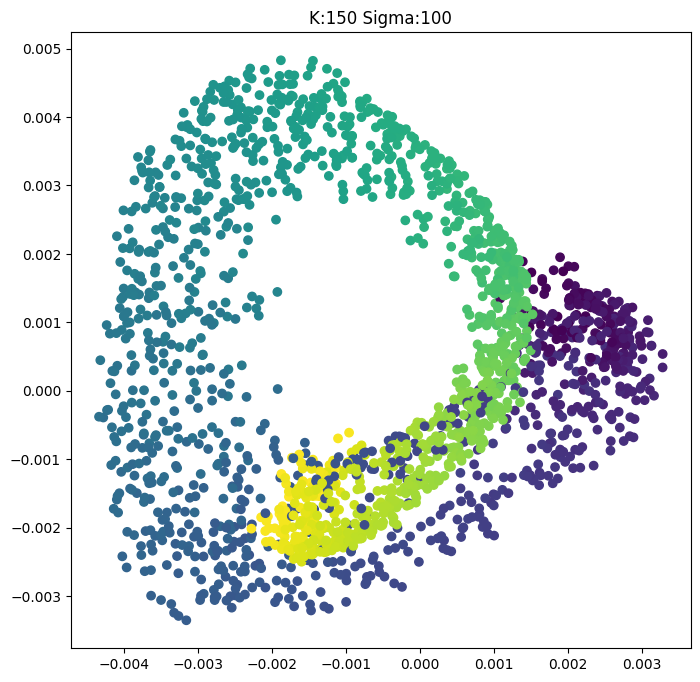

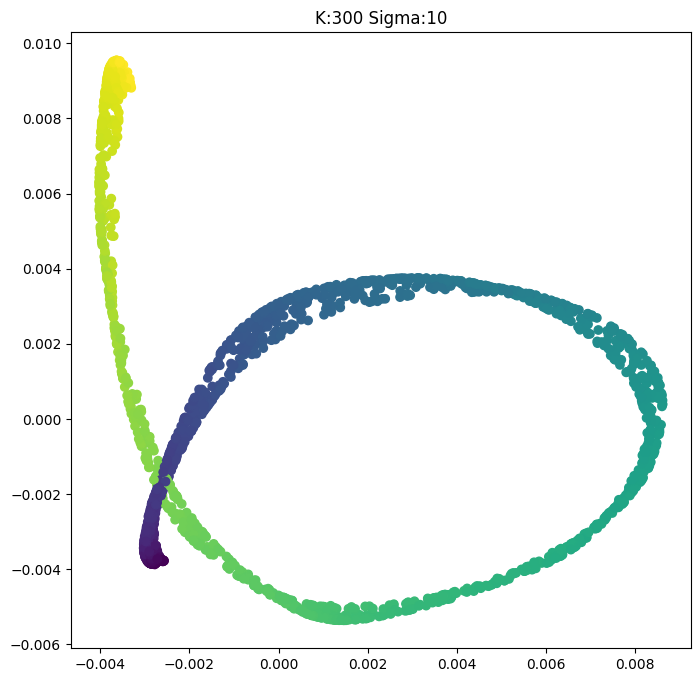

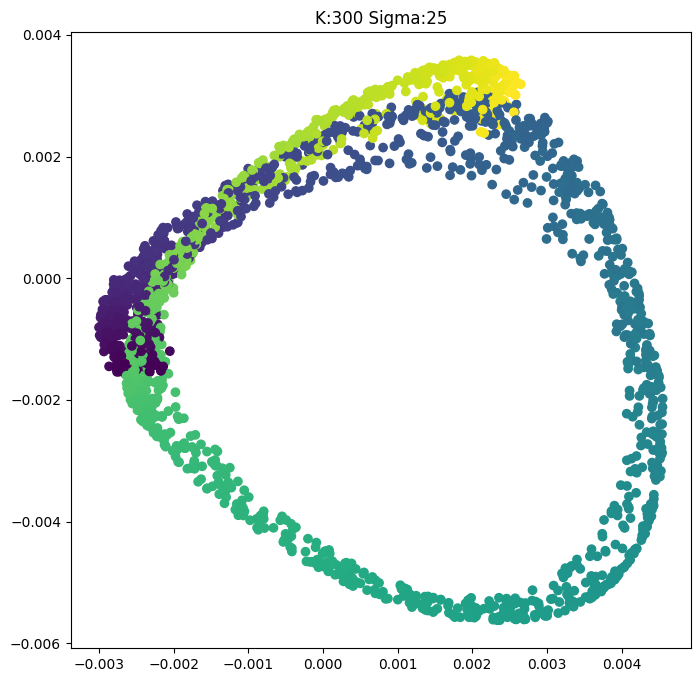

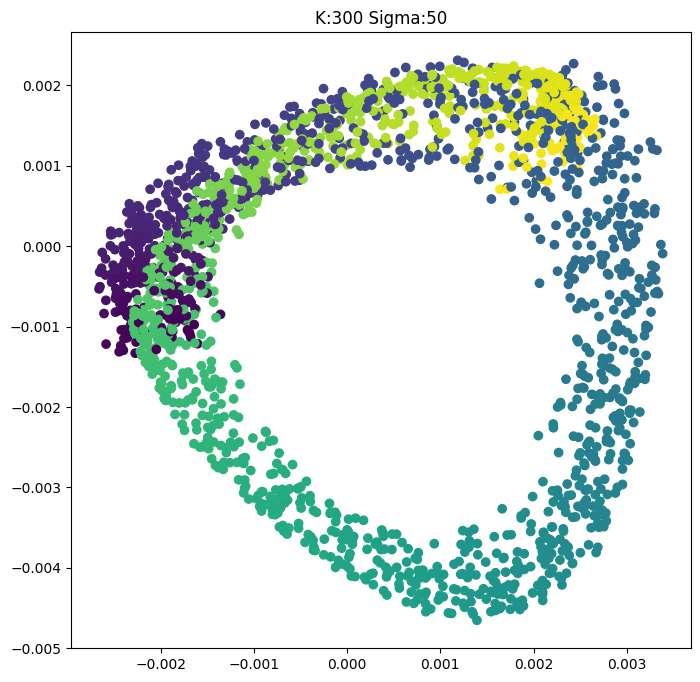

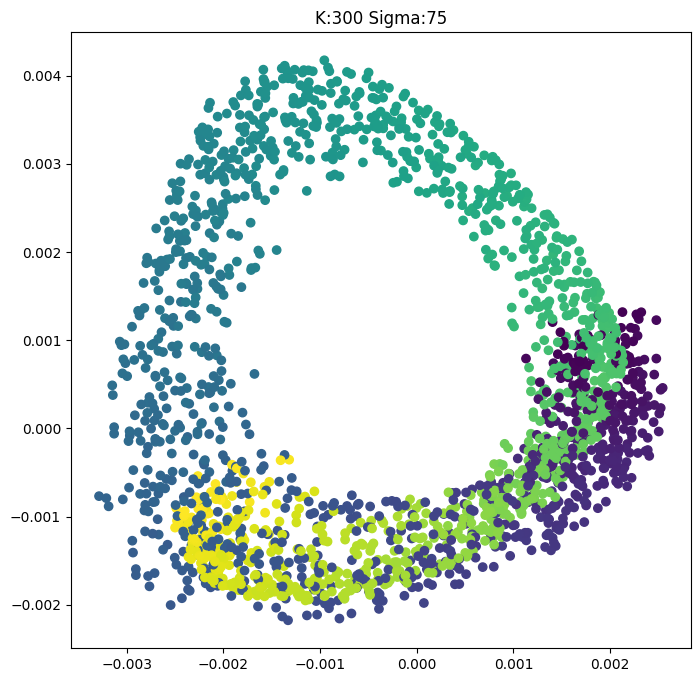

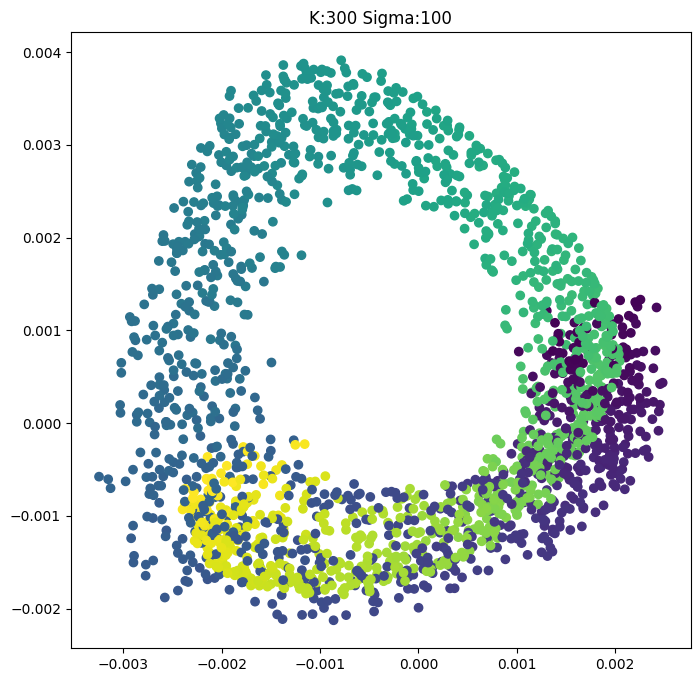

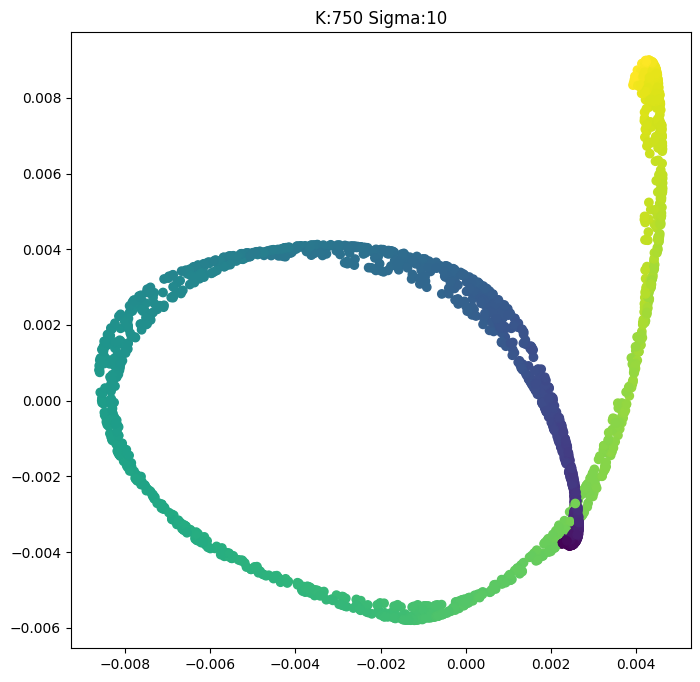

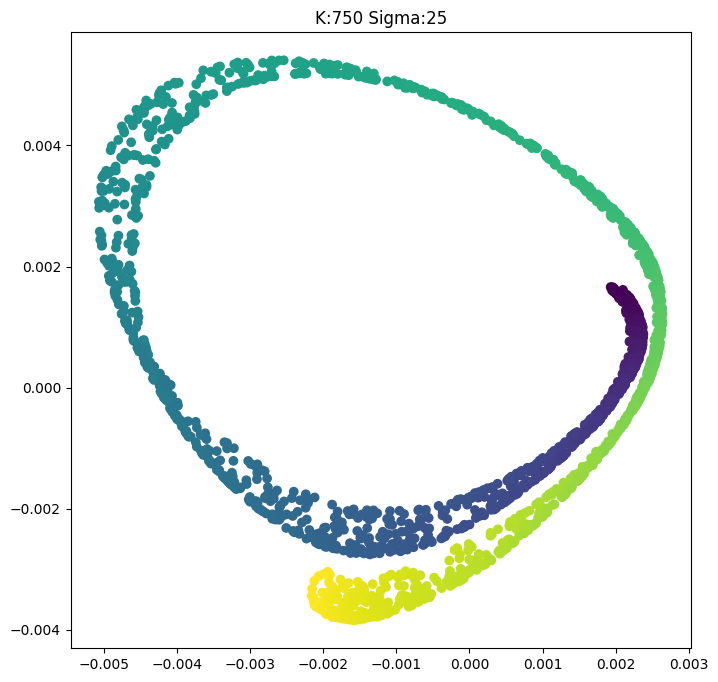

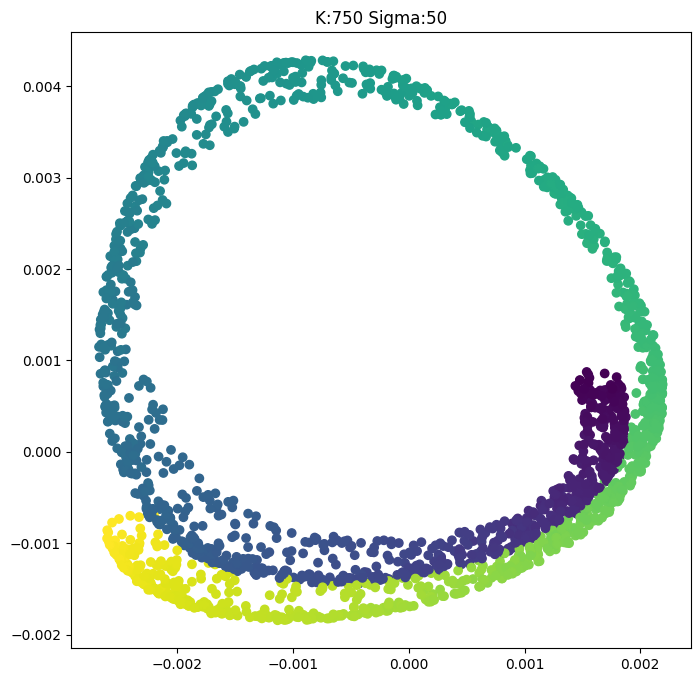

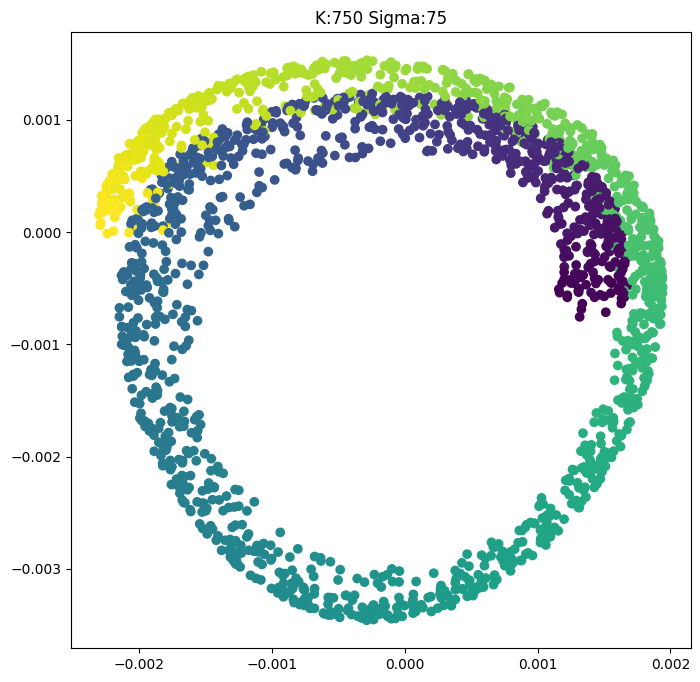

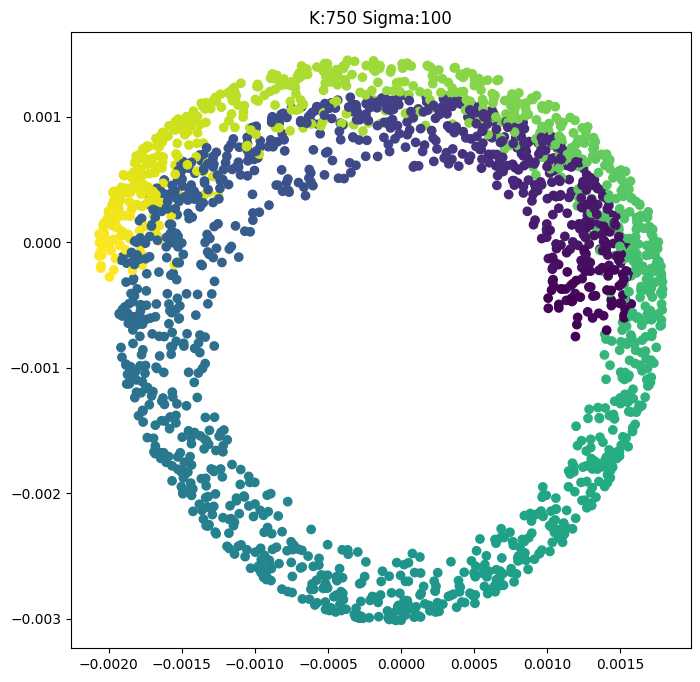

In [ ]:
import matplotlib.pyplot as plt

from sklearn import datasets, manifold

sr_points, sr_color = datasets.make_swiss_roll(n_samples=2000, random_state=0)

sigmas = [10,25,50,75,100]
ks = [10, 50, 150, 300, 750]
for k in ks:
  for sigma in sigmas:
    draw2D(tryToEmbed(sr_points,k,2, mode = "distance", sigma = sigma), k, sigma, colors = sr_color)
    #draw2D(tryToEmbed(sr_points,k,2, mode = "connectivity", sigma = sigma), k, sigma, colors = sr_color)

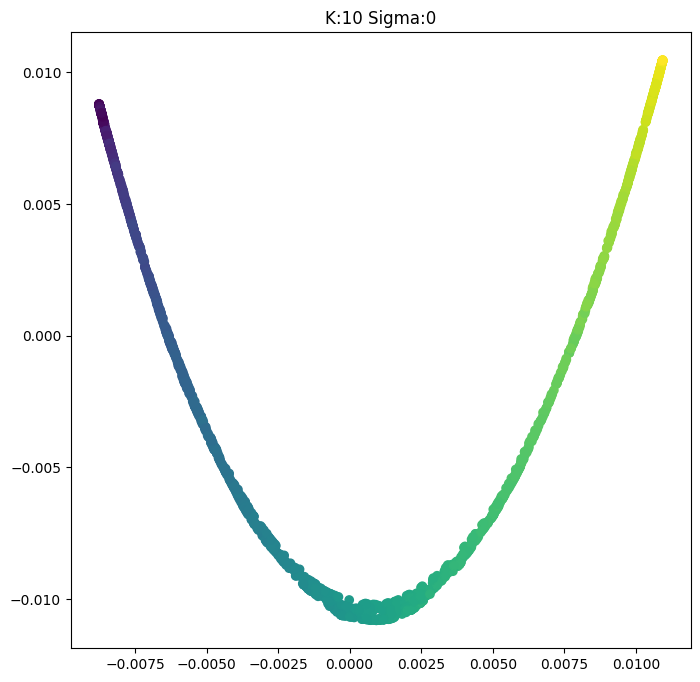

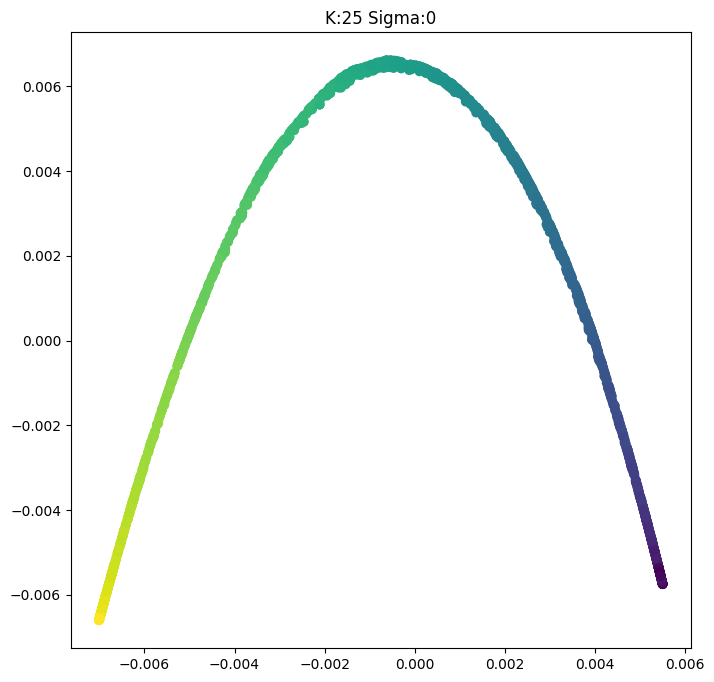

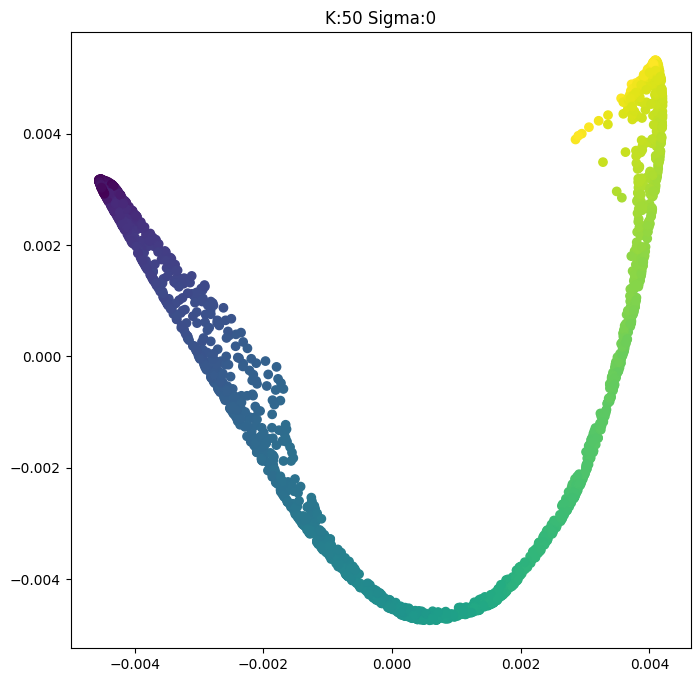

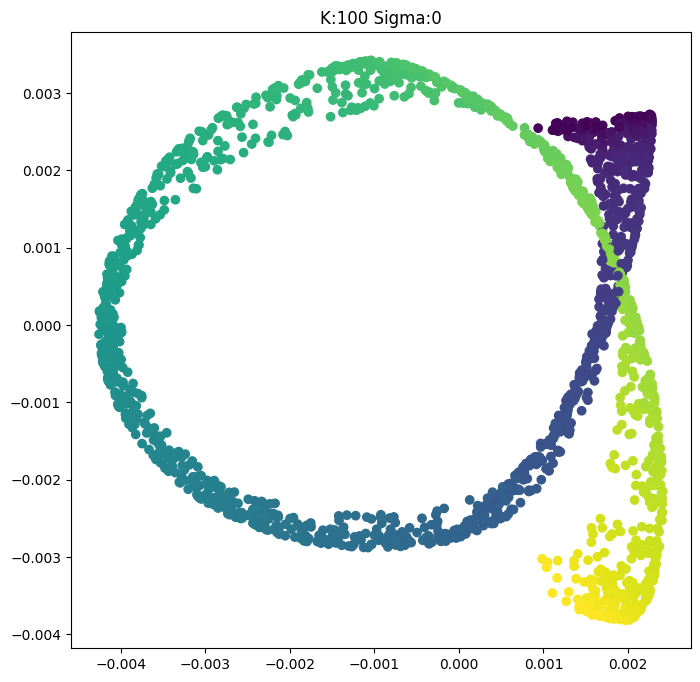

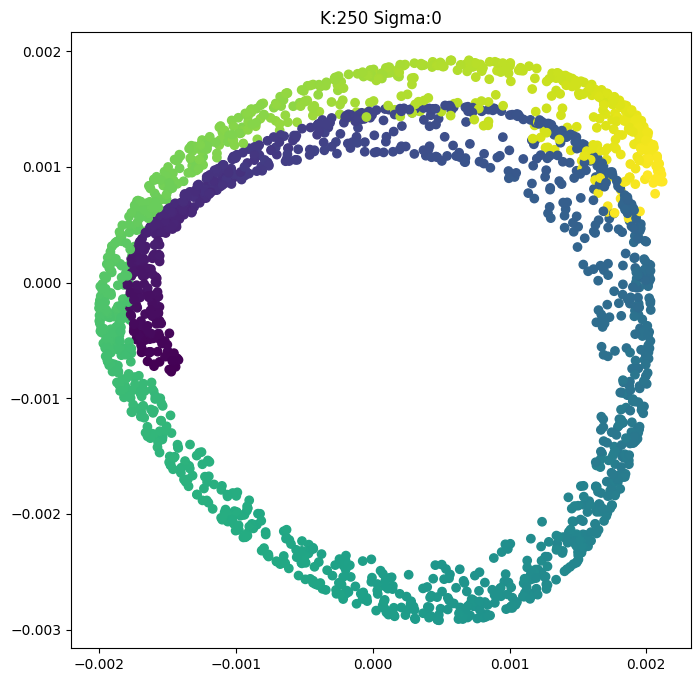

In [ ]:
import matplotlib.pyplot as plt

from sklearn import datasets, manifold

sr_points, sr_color = datasets.make_swiss_roll(n_samples=2000, random_state=0)

sigmas = [10,25,50,75,100]
ks = [10, 25, 50, 100, 250]
for k in ks:
  #for sigma in sigmas:
    #draw2D(tryToEmbed(sr_points,k,2, mode = "distance", sigma = sigma), k, sigma, colors = sr_color)
  draw2D(tryToEmbed(sr_points,k,2, mode = "connectivity", sigma = 0), k, 0, colors = sr_color)

(150, 3)


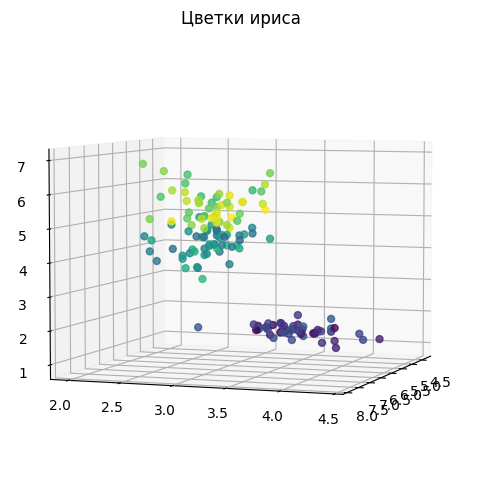

In [ ]:
from sklearn import datasets
data = datasets.load_iris()

data = data['data'][:,:-1]
print(data.shape)

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection="3d")
fig.add_axes(ax)
ax.scatter(
    data[:, 0], data[:, 1], data[:, 2], c = np.linspace(0, 25, data.shape[0]), cmap='viridis', s=25, alpha=0.8
)
ax.set_title("Цветки ириса")
ax.view_init(azim=20, elev=5)

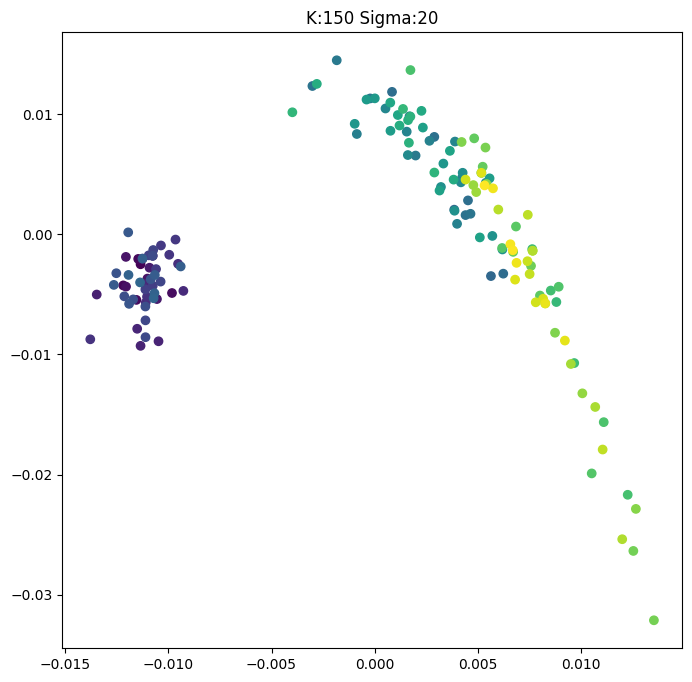

In [ ]:
#sigmas = [1/10, 1/5, 10, 20]
#ks = [10, 25, 50, 100,150]
#for k in ks:
#  for sigma in sigmas:
draw2D(tryToEmbed(data,150,2, mode = "distance", sigma = 20), 150, 20)

In [ ]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
#https://www.kaggle.com/datasets/waalbannyantudre/banking-sector-of-the-waemu
data = pd.read_csv("WAEMU_Banking.csv")

data = data.drop("Banks", axis = 1)
data = data.drop("Countries", axis = 1)
data = data.drop("Countries_Num", axis = 1)
data = data.drop("Year", axis = 1)
data = data.drop("Unnamed: 0", axis = 1)
data = data.drop("id", axis = 1)

scaler = StandardScaler()
data = scaler.fit_transform(data)

data


array([[ 0.03039782, -0.61981329, -0.07547279, ...,  0.21216742,
         0.1597642 ,  1.33708122],
       [ 0.45931331, -0.24288585, -0.84623557, ..., -0.44171355,
         0.33598039,  1.45225364],
       [ 0.1349248 , -0.11908415, -0.24111503, ..., -0.49249348,
         0.09872382,  1.58582023],
       ...,
       [ 0.45905825,  1.28080787, -1.18644932, ..., -1.45731107,
        -0.7554024 , -1.08551622],
       [-1.24254656,  1.42429637,  0.31815385, ..., -0.89873185,
        -0.32833979, -1.35458536],
       [-1.48121644,  1.29755478,  0.12714928, ..., -1.00029171,
        -0.42324182, -1.2672618 ]])

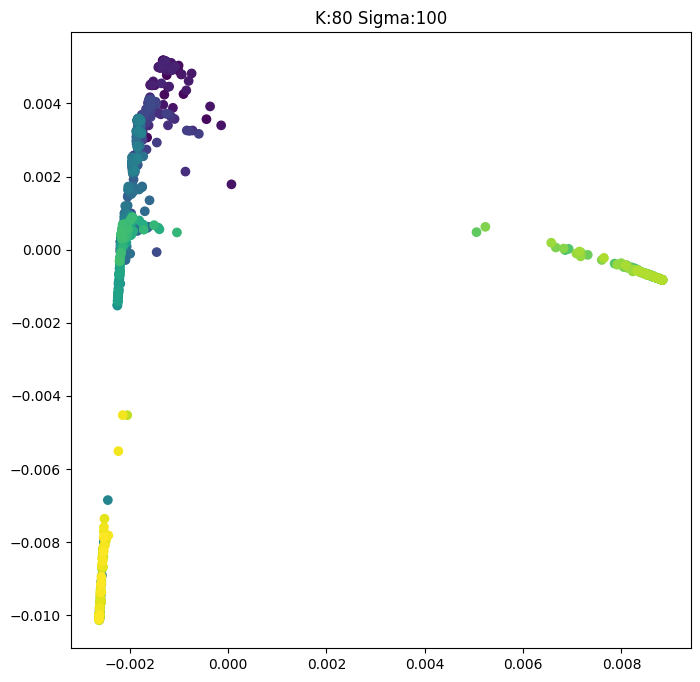

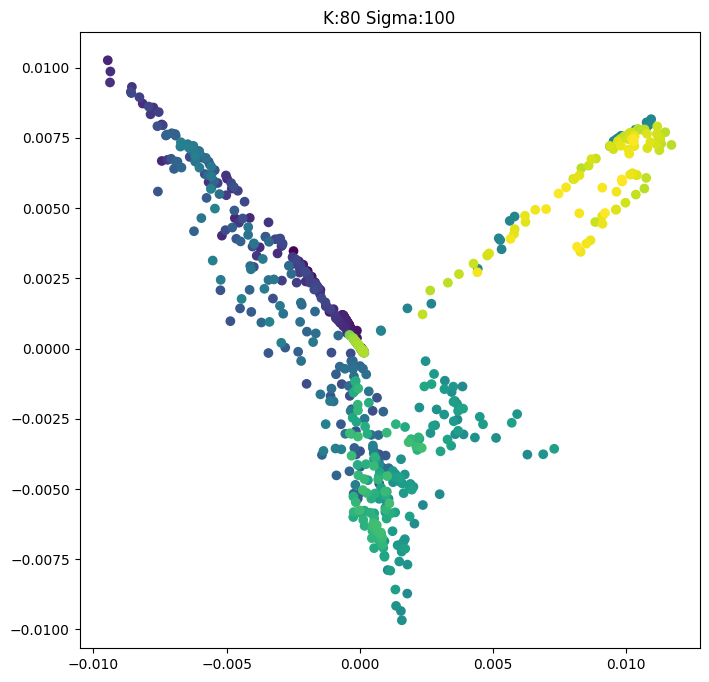

In [ ]:
# k = 10 sigma 10
# k = 559 sigma = 10000 in 3
# k 80 sigma = 100

draw2D(tryToEmbed(data, 80, 2, mode = "connectivity", sigma = 100), 80, 100)
draw2D(tryToEmbed(data, 80, 2, mode = "distance", sigma = 100), 80, 100)